## Load libraries

In [1]:
library(ggplot2)
library(dplyr)
library(reshape)
library(reshape2)
library(ComplexHeatmap)
library(circlize)
library(RColorBrewer)
library(data.table)
library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into a

## Set paths to reference files

In [2]:
#Differential regulons (cancer cells from each primary tumor vs cancer cells from all other primary tumors)
d_regs=read.table('../data/snRNA/Table_S4b_regulons_T_vs_other_T.txt',sep='\t',header=T)

#Differential regulons (cancer cells from each primary tumor vs theirs CNC)
regs_tn=read.table('../data/snRNA/Table_S4c_regulons_T_vs_CNC.txt',sep='\t',header=T)

#Annotation of regulons
annot_r=read.table('../data/snRNA/Regulons_new_annot.20230124.tsv',sep='\t',header=T)

#AUC scores per 200 random cells per primary tumor type and per normal cell type
path_to_AUC_table='../data/snRNA/AUC_200_sampled_cancer_cells_per_primary_tumor_type_and_per_normal_cell_type.tsv'

#Cell type annotation of table with AUC scores
path_to_AUC_table_annot='../data/snRNA/Annot_AUC_200_sampled_cancer_cells_per_primary_tumor_type_and_per_normal_cell_type.tsv'

#Color scale for regulon types
cols_type=c('Cancer_specific'='#E7298A','Tissue_specific'='#1B9E77','NA'='grey')

#Color scale for cancer types
cols=readRDS('../data/Colors_panatac_v2.0.rds')
dis_cols_ed <- cols$Cancer

In [3]:
#Add annotation, and filter regulons to the ones with >=20 target genes
d_regs$cell_group_1=gsub('^Tumor_','',d_regs$cell_group_1)
d_regs=merge(d_regs,annot_r,all.x=T)
d_regs=d_regs[d_regs$Genes_N>=20,]
d_regs$Fch=d_regs$Regulon_Score_group1/d_regs$Regulon_Score_group2

d_regs=d_regs[order(-d_regs$Fch),]

In [4]:
#Prioritize top 10 regulons in each cancer
all_d_r1=NULL
for (can in unique(d_regs$cell_group_1)){
    d_r1=d_regs[d_regs$cell_group_1==can & d_regs$FDR<0.05 & 
                d_regs$Fch>1.5 & d_regs$Regulon_Score_group1>median(d_regs$Regulon_Score_group1),]
    all_d_r1=rbind(all_d_r1,d_r1[1:10,]) 
}
all_d_r1=all_d_r1[!is.na(all_d_r1$Regulon),]

In [5]:
#Additionally add selected T/N TFs
d_regs_sel=d_regs
d_regs_sel$ID=paste(d_regs_sel$cell_group_1,d_regs_sel$Regulon,sep='__')

d_regs_sel=d_regs_sel[d_regs_sel$ID %in% c('PDAC__KLF6(+)','GBM__NRF1(+)','BRCA__RARA(+)','ccRCC__MXI1(+)','GBM__E2F7(+)','PDAC__ELF3(+)'),]
d_regs_sel=d_regs_sel[,1:(ncol(d_regs_sel)-1)]
d_regs_sel$Count=1

In [6]:
#Keep regulons from the top 10 list (cancer cells from each primary tumor vs cancer cells from all other primary tumors),
#and also from the selected list

rownames(annot_r)=annot_r$Regulon
annot_r=annot_r[annot_r$Regulon %in% c(all_d_r1$Regulon, d_regs_sel$Regulon),]
annot_r$Regulon_1=gsub('\\(\\+\\)','',annot_r$Regulon)
annot_r$ID=paste(annot_r$Regulon_1,' (',annot_r$Genes_N,'g',')',sep='')

In [7]:
#Annotate by cancer type:
all_d_r1=all_d_r1[order(-all_d_r1$Fch),]
all_d_r1=all_d_r1[!duplicated(all_d_r1$Regulon),]

all_d_r2=all_d_r1[,c('Regulon','cell_group_1')]
all_d_r2=rbind(all_d_r2,d_regs_sel[,c('Regulon','cell_group_1')])

annot_r=merge(annot_r, all_d_r2)

In [8]:
#Use differential regulons (cancer cells from each primary tumor vs theirs CNC) to annotatate cancer cell-specific
#and tissue-specific regulons

regs_tn$log2_Fch=log2(regs_tn$Regulon_Score_group1/regs_tn$Regulon_Score_group2)
regs_tn=regs_tn[regs_tn$FDR<0.05 & regs_tn$Score_diff>0.01 & regs_tn$log2_Fch>0.1,]

regs_tn_s=regs_tn[,c('Regulon','cell_group_1')]
regs_tn_s$cell_group_1=gsub('^Tumor_','',regs_tn_s$cell_group_1)
regs_tn_s$Regulon_type='Cancer_specific'

In [9]:
#Add regulons annotation
annot_r2=merge(annot_r,regs_tn_s,all.x=T)
annot_r2$Regulon_type=ifelse(is.na(annot_r2$Regulon_type),'Tissue_specific',annot_r2$Regulon_type)

rownames(annot_r2)=annot_r2$Regulon
annot_r2$ID=paste(annot_r2$Regulon_1,annot_r2$cell_group_1,sep='__')

In [10]:
#Read table with AUC scores per 200 random cells per cell group (primary cancer cells from each tumor type and normal cells)
tab=read.table(path_to_AUC_table,sep='\t',header=T)
colnames(tab)=gsub('\\.','\\-',colnames(tab))

info=read.table(path_to_AUC_table_annot,sep='\t',header=T)
rownames(info)=info$Barcode
info=info[colnames(tab),]

In [11]:
#Format table
info$Disease=gsub('(.*)_(.*)_(.*)','\\1',info$Barcode)
info$Disease=gsub('(.*)_(.*)','\\1',info$Disease)
info$Disease=ifelse(info$Piece_ID %in% c("HT268B1-Th1H3", "HT029B1-S1PC", "HT035B1-S1PA","HT1408-06","HT141B1-S1H1", "HT206B1-S1H4", "HT271B1-S1H3","HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1"),'BRCA_Basal', info$Disease)
info$Disease=ifelse(info$cell_type.detailed=='Luminal mature','BRCA',info$Disease)
info$Disease=ifelse(info$cell_type.detailed=='Luminal progenitor','BRCA_Basal',info$Disease)

In [12]:
tab_s=tab[rownames(tab) %in% c(annot_r2$Regulon),]

rownames(annot_r2)=annot_r2$Regulon
annot_r2=annot_r2[rownames(tab_s),]

In [13]:
info$Type=ifelse(info$cell_type.detailed=='Tumor','Tumor','Normal')
info$Type_1=ifelse(info$Type=='Tumor',1,2)
info=info[order(info$Type_1),]

info=info%>%mutate(Disease=factor(info$Disease,levels=c('HNSCC','CESC','PDAC','CRC','MM','BRCA','BRCA_Basal','OV','UCEC','GBM','ccRCC','SKCM'))) %>% arrange(Disease)
tab_s1=tab_s[,info$Barcode]

## Do plotting with ComplexHeatmap

In [14]:
row_ha=rowAnnotation(Disease=info$Disease, cell_type=info$Type,col=list(Disease=dis_cols_ed,
                                                                        cell_type=c('Tumor'='black','Normal'='grey')))
column_ha=HeatmapAnnotation(Regulon_type=annot_r2$Regulon_type,
                            ID=anno_text(annot_r2$Regulon,gp = gpar(fontsize = 10)),
                            col=list(snATAC=c('Yes'='black','No'='light grey'),Regulon_type=cols_type))
column_ha_2=HeatmapAnnotation(log2_Genes_N = anno_barplot(log2(annot_r2$Genes_N),bar_width = 0.6, 
                                                          height = unit(1.5, "cm"), name="log2(Genes_N)"))

In [15]:
x=ComplexHeatmap::Heatmap(scale(t(tab_s1)), name="AUC, scaled", 
                          col= colorRamp2(c(-2, 0, 2), c("#377EB8", "white", "#E41A1C")),
cluster_rows = F, cluster_columns=TRUE, show_column_names = F, row_names_gp=grid::gpar(fontsize=6),
                          right_annotation=row_ha,show_column_dend=F,show_row_dend=F,
                          row_split=factor(info$Disease,
                                           levels=c('HNSCC','CESC','PDAC','CRC','MM','BRCA','BRCA_Basal','OV','UCEC','GBM','ccRCC','SKCM')),
                          show_row_names=F,column_split=factor(annot_r2$cell_group_1,levels=c('HNSCC','CESC','PDAC','CRC','MM','BRCA','BRCA_Basal','OV','UCEC','GBM','ccRCC','SKCM')),
                          cluster_column_slices=F,cluster_row_slices=F,row_title=NULL,
                          use_raster=T,bottom_annotation=column_ha,top_annotation=column_ha_2,
                          row_order=info$Barcode)

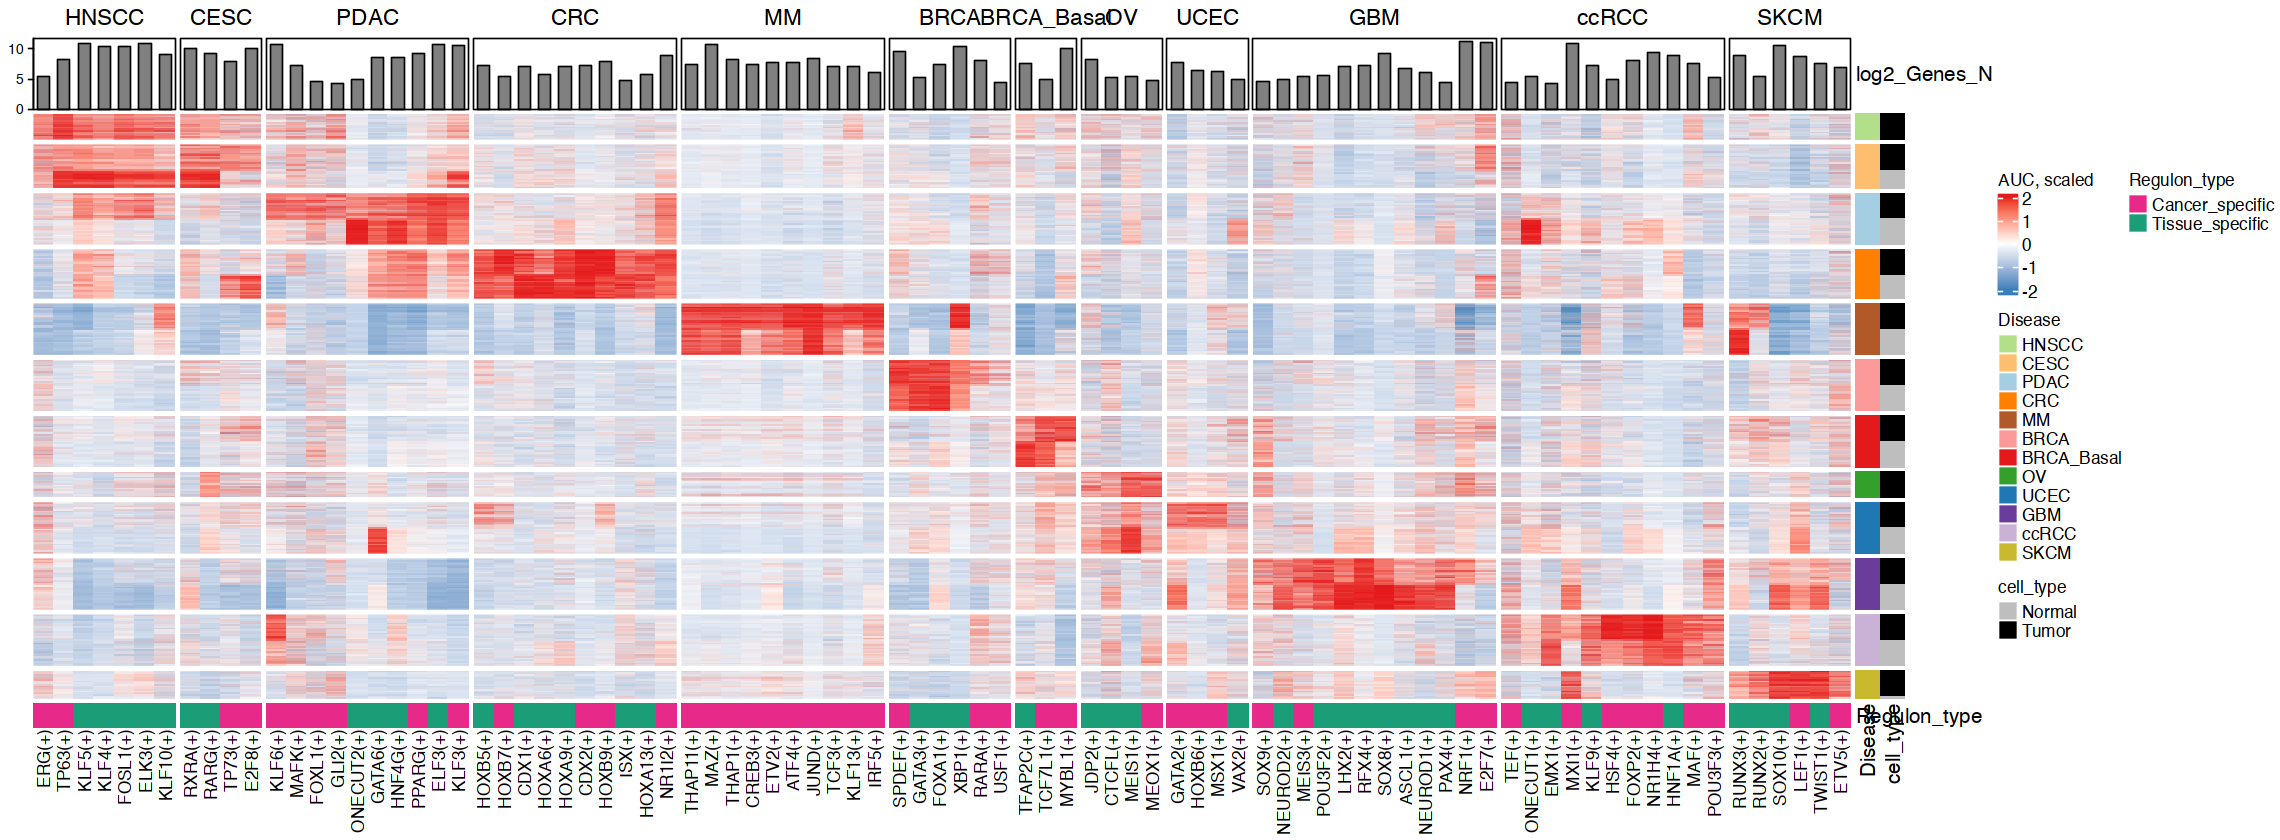

In [16]:
options(repr.plot.width=19, repr.plot.height=7)
x